In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy import signal, interpolate

df = pd.read_csv('./data/eeg-eye-state.csv')

fs = df.shape[0]/117
t = np.arange(0, len(df) * 1 / fs, 1/fs)
cols = df.columns.tolist()[:-1]

Y = df['class']
X = df.drop(columns="class")

In [ ]:
# Find outliers and put Nan instead
X = X.apply(stats.zscore, axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

# recalculate outliers with ignoring nans since the first calculation was biased with the huge outliers!
X = X.apply(stats.zscore, nan_policy='omit', axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel_72121/2796526811.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )
/var/folders/4j/tlx3f80d0rz_mzn5sy7p20ww0000gn/T/ipykernel_72121/2796526811.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )


In [ ]:
def interp(x):
    t_temp = t[x.index[ ~x.isnull()]]
    x = x[x.index[ ~x.isnull()]]
    clf = interpolate.interp1d(t_temp, x, kind='cubic')
    return clf(t)

# interpolate the nans using cubic spline method
X_interp = X.apply(interp, axis=0)

In [226]:
# ICA
from sklearn.decomposition import FastICA

# apply ICA to drop non-electrophysiolgoical components (requires familiarity with EEG data)
ica = FastICA(max_iter=2000, random_state=0)
X_pcs = pd.DataFrame( ica.fit_transform(X_interp) )
X_pcs.columns = ['PC' + str(ind+1) for ind in range(X_pcs.shape[-1])]
X_pcs = X_pcs.drop(columns=['PC1', 'PC7'])

# reconstruct clean EEG after dropping the bad components
ica.mixing_ = np.delete(ica.mixing_, [0, 6], axis = 1)
X_interp_clean = pd.DataFrame( ica.inverse_transform(X_pcs) )
X_interp_clean.columns = cols

/Users/zacariabalkhy/Library/Python/3.12/lib/python/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [ ]:
b, a = signal.butter(6, [8 / fs * 2, 13 / fs * 2], btype='bandpass')
X_interp_clean_alpha = X_interp.apply(lambda x: signal.filtfilt(b, a, x) / max(abs(signal.filtfilt(b, a, x))) * max(abs(x)), axis=0)

#X_interp_clean_alpha = X_interp_clean_alpha.apply(lambda x: np.abs(signal.hilbert(x)), axis=0)


In [271]:
# sliding window alpha power calculation on O2 channel
O2 = X['O1']
alpha_power = np.zeros(t.shape)
window_size = int(fs)
for i in range(alpha_power.size):
    if i < window_size:
        alpha_power[i] = 0
        continue
    O2_chunk = O2[i-window_size:i]
    b, a = signal.butter(6, [8 / fs * 2, 13 / fs * 2], btype='bandpass')
    O2_chunk = signal.filtfilt(b, a, O2_chunk) / max(abs(signal.filtfilt(b, a, O2_chunk))) * max(abs(O2_chunk))
    #O2_chunk = np.abs(signal.hilbert(O2_chunk))
    freqs = np.fft.fftfreq(O2_chunk.shape[0], d=1/fs)
    chunk_fft = np.fft.fft(O2_chunk)
    alpha_power[i] = np.sum(np.abs(chunk_fft[np.where((freqs>= 8) & (freqs <=13))]))


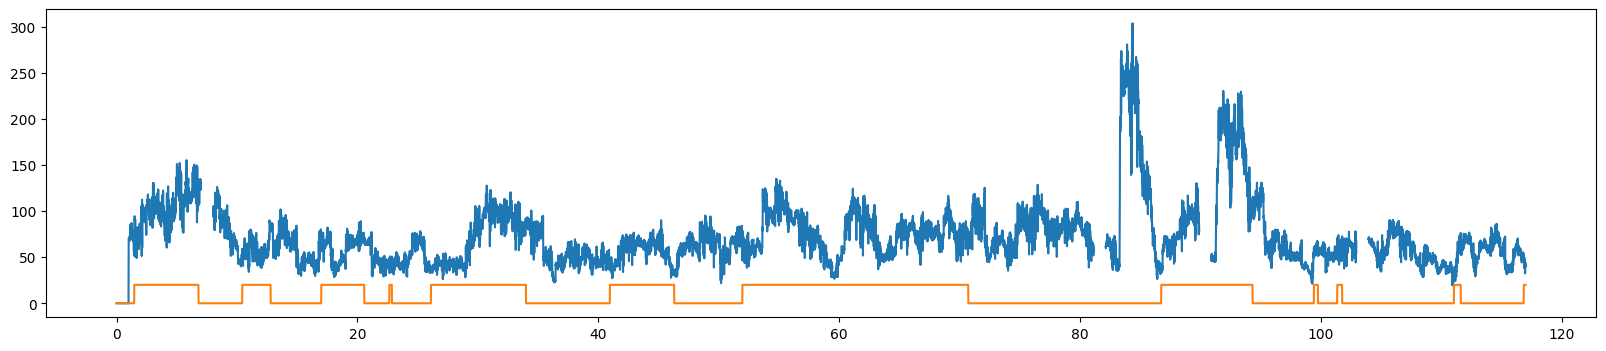

In [272]:
plt.figure(figsize=(20,4))

plt.plot(t, alpha_power)
plt.plot(t, Y*20)

AF3 open:  74.12473542976569
AF3 closed:  60.5141751046927
F7 open:  127.60367916997117
F7 closed:  109.12228253833995
F3 open:  126.20501178715027
F3 closed:  61.53721611022048
FC5 open:  99.05685567156199
FC5 closed:  85.03906222505749
T7 open:  538.1425816418578
T7 closed:  344.7135790210225
P open:  150.72259540114402
P closed:  121.87892501767107
O1 open:  83.66371162576736
O1 closed:  81.75904182177277
O2 open:  375.33226183827315
O2 closed:  262.20155345405766
P8 open:  84.67510386740446
P8 closed:  50.487305666211206
T8 open:  177.03631312162517
T8 closed:  129.81994840529717
FC6 open:  227.4737575262385
FC6 closed:  140.09170503992425
F4 open:  277.12114854049696
F4 closed:  100.02124639901898
F8 open:  103.26218819254348
F8 closed:  72.9802777525645
AF4 open:  105.9335473173799
AF4 closed:  38.72118212917337


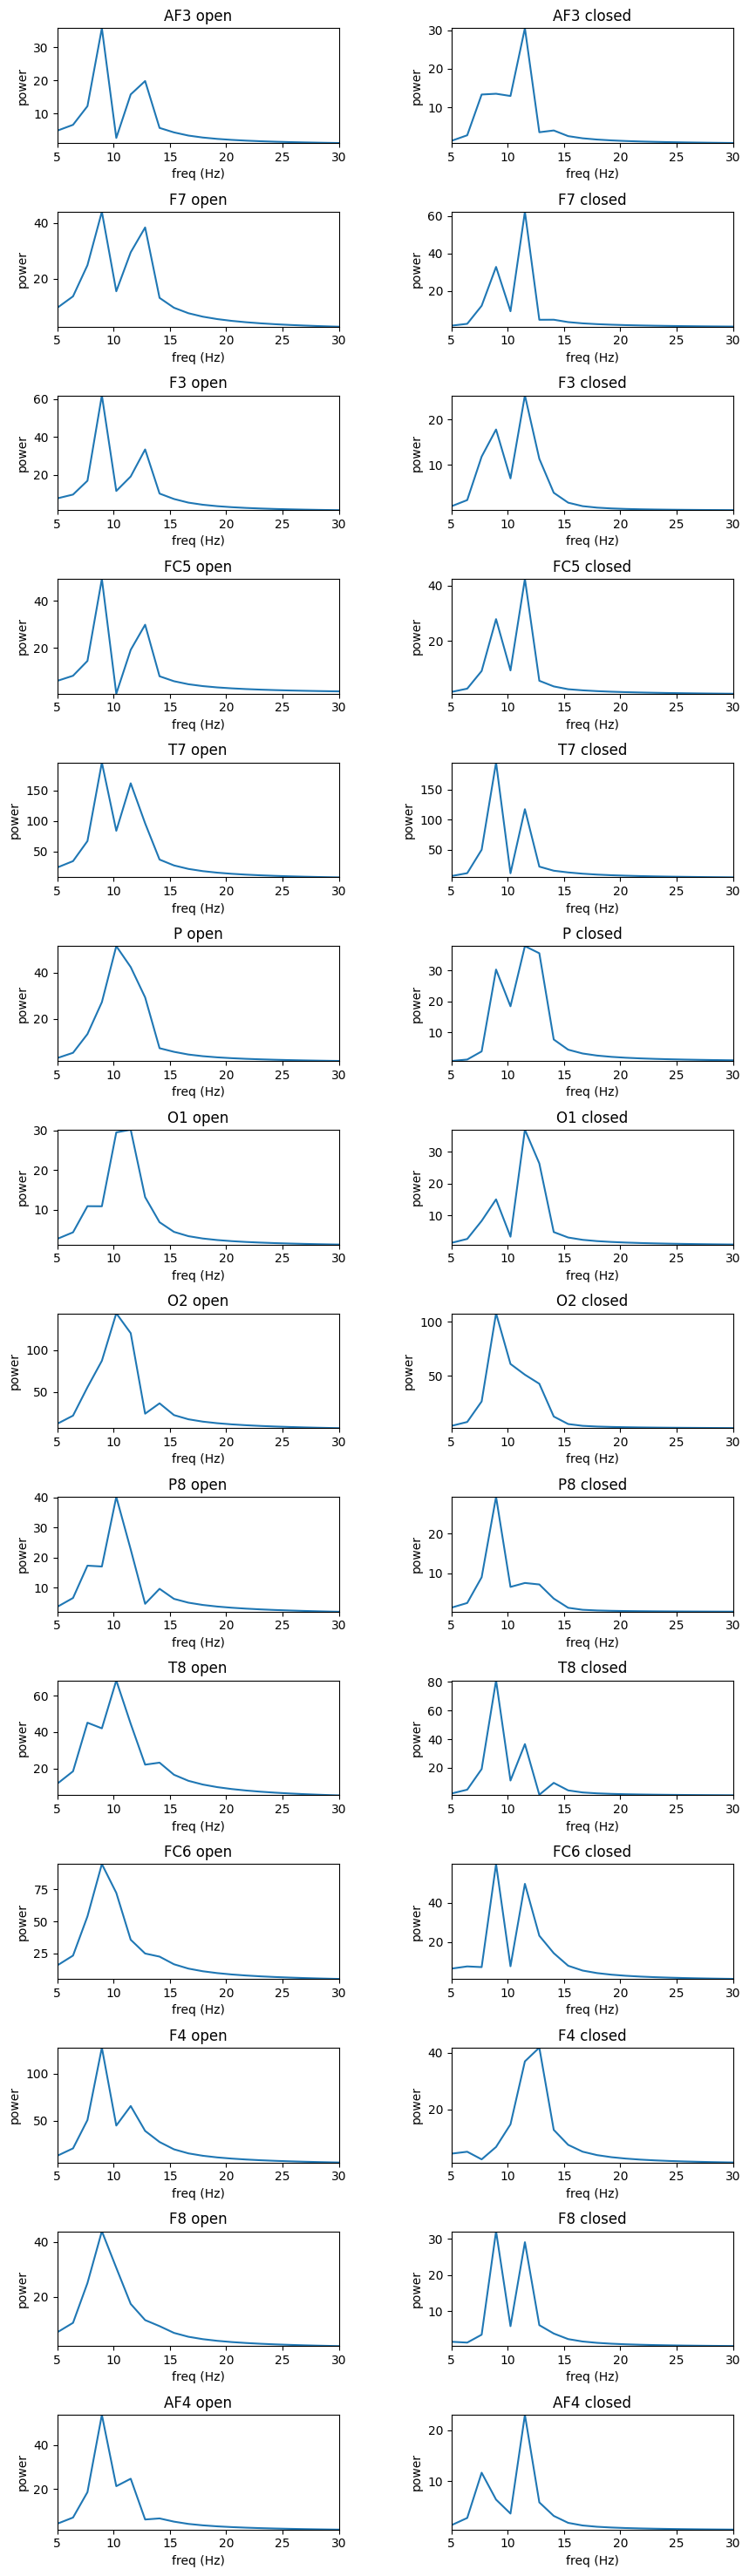

In [242]:
plt.figure(figsize=(10,40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
xlims = (5,30)

i = 1
for key in X.keys():
    open = np.array(X_interp_clean_alpha.iloc[np.where(Y==0)][key])
    closed = np.array(X_interp_clean_alpha.iloc[np.where(Y==1)][key])

    open = open[300:400]
    closed = closed[300:400]

    freqs_open = np.fft.fftfreq(open.shape[0], d=1/fs)
    open_fft = np.fft.fft(open)

    freqs_closed = np.fft.fftfreq(closed.shape[0], d=1/fs)
    closed_fft = np.fft.fft(closed)

    open_fft_power = np.abs(open_fft)
    closed_fft_power = np.abs(closed_fft)
    
    alpha_power_open = np.sum(open_fft_power[np.where((freqs_open>= 8) & (freqs_open <=13))])
    alpha_power_closed = np.sum(closed_fft_power[np.where((freqs_closed>= 8) & (freqs_closed <=13))])
    
    print(key + " open: ", alpha_power_open)
    print(key + " closed: ", alpha_power_closed)
    
    ax1 = plt.subplot(15, 2, i)
    ax1.set_title(key + " open")
    ax1.set_xlabel("freq (Hz)")
    ax1.set_ylabel('power')
    ax1.set_ylim((np.min(open_fft_power[np.where((freqs_open>= xlims[0]) & (freqs_open <=xlims[1]))]), 
                  np.max(open_fft_power[np.where((freqs_open>= xlims[0]) & (freqs_open <=xlims[1]))])))
    ax1.set_xlim(xlims)
    ax1.plot(np.fft.fftshift(freqs_open), np.fft.fftshift(open_fft_power))

    ax2 = plt.subplot(15, 2, i+1)
    ax2.set_title(key + " closed")
    ax2.set_xlabel("freq (Hz)")
    ax2.set_ylabel('power')
    ax2.plot(np.fft.fftshift(freqs_closed), np.fft.fftshift(closed_fft_power))
    ax2.set_ylim((np.min(closed_fft_power[np.where((freqs_closed>= xlims[0]) & (freqs_closed <=xlims[1]))]), 
                  np.max(closed_fft_power[np.where((freqs_closed>= xlims[0]) & (freqs_closed <=xlims[1]))])))
    ax2.set_xlim(xlims)

    i += 2
plt.show()



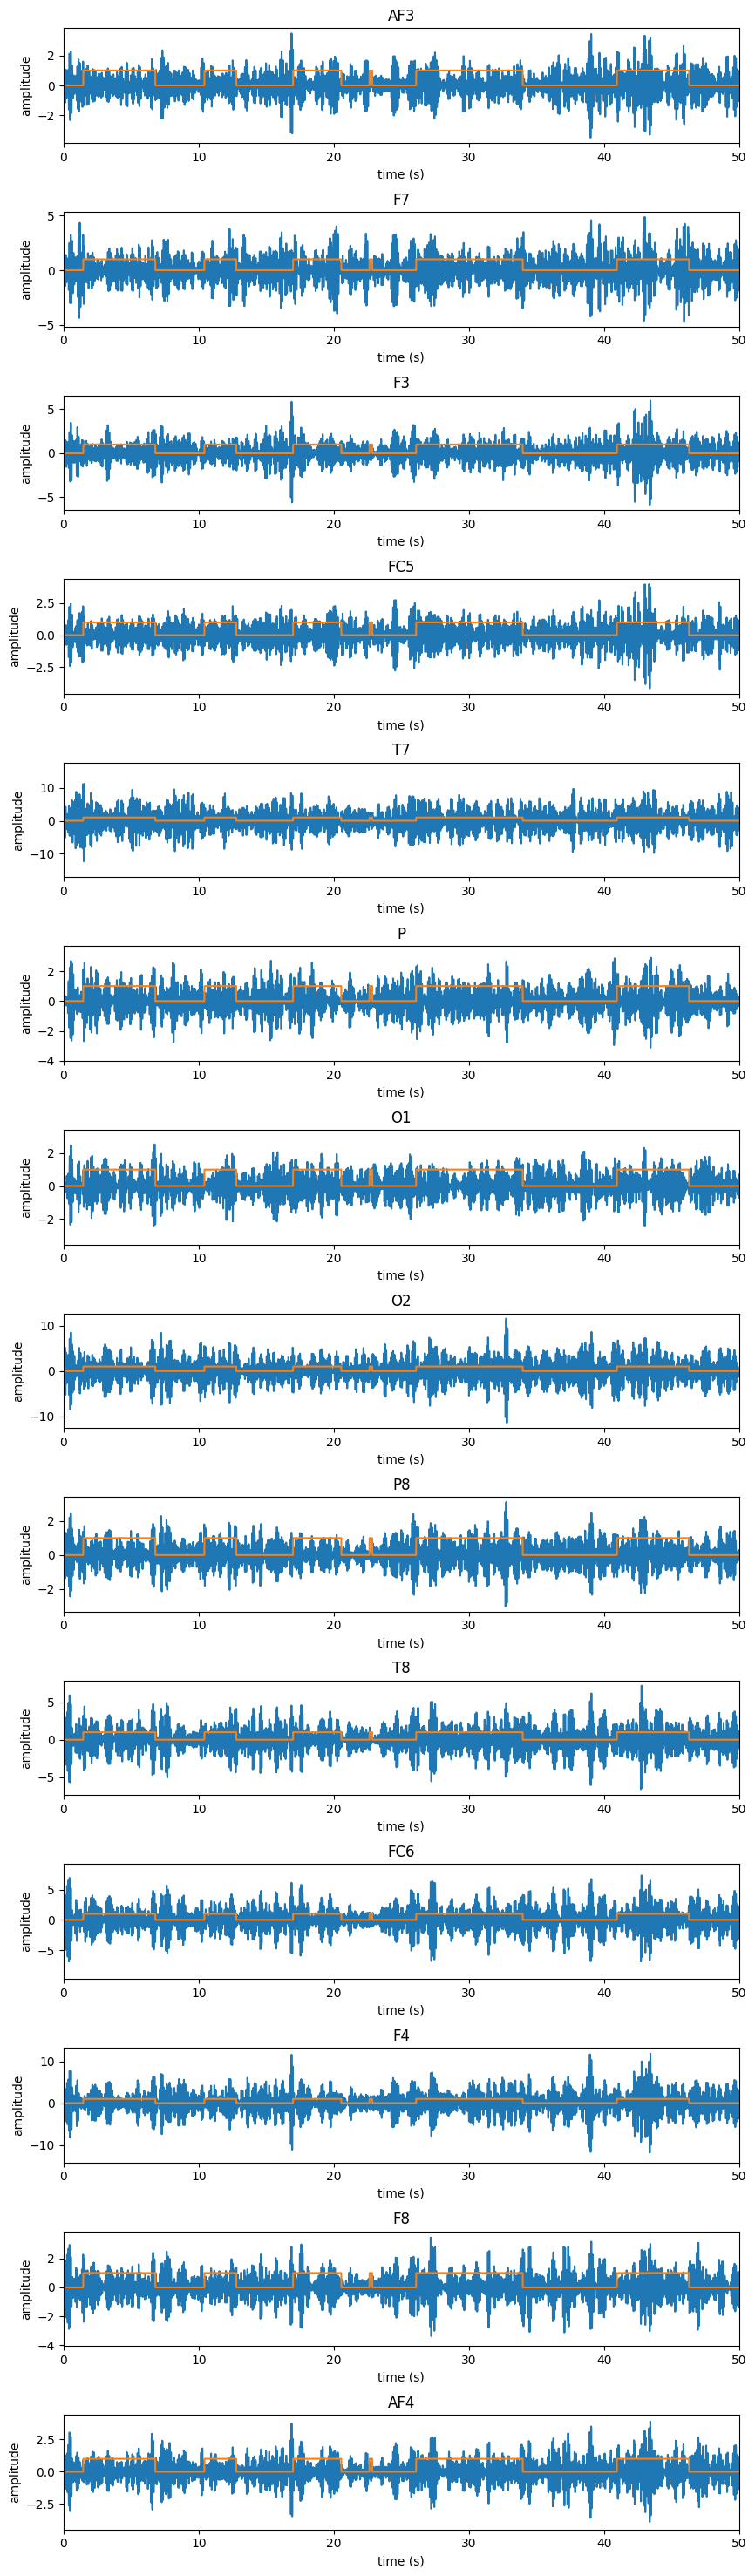

In [243]:
plt.figure(figsize=(10,40))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
xlims = (5,30)


for i, key in enumerate(X.keys()):
    channel = X_interp_clean_alpha[key]
    ax1 = plt.subplot(15, 1, i+1)
    ax1.set_title(key)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel('amplitude')
    ax1.plot(t, channel)
    ax1.plot(t, Y)
    ax1.set_xlim((0,50))
